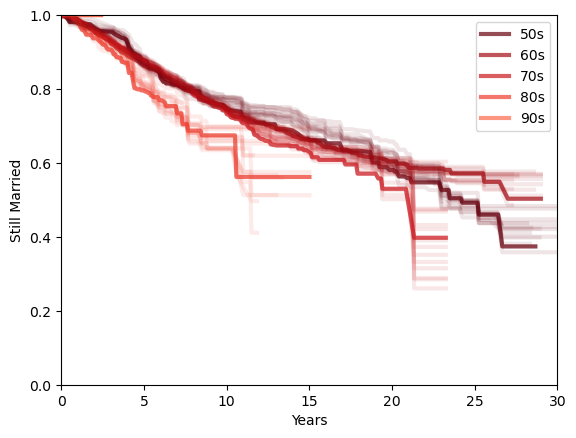

In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import thinkstats2
import thinkplot
import survival

# Load NSFG Cycles 6 and 7
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

# Function to preprocess the data
def ProcessMarriageData(df):
    """Prepares marriage data for survival analysis."""
    df["cmdivorcx"] = df["cmdivorcx"].replace([9998, 9999], np.nan)
    df["cmmarrhx"] = df["cmmarrhx"].replace([9997, 9998, 9999], np.nan)
    df["still_married"] = df["cmdivorcx"].isna().astype(int)

    # Compute marriage duration in years
    df["marriage_length"] = (df["cmdivorcx"] - df["cmmarrhx"]) / 12.0
    df["current_marriage_length"] = (df["cmintvw"] - df["cmmarrhx"]) / 12.0

    # Extract decade of birth
    base_date = pd.to_datetime("1899-12-15")
    birth_dates = [base_date + pd.DateOffset(months=cm) for cm in df["cmbirth"]]
    df["birth_decade"] = (pd.DatetimeIndex(birth_dates).year - 1900) // 10

# Process both datasets
ProcessMarriageData(resp6)
ProcessMarriageData(resp7)

# Filter only those who have ever been married
married_respondents6 = resp6[resp6["evrmarry"] == 1]
married_respondents7 = resp7[resp7["evrmarry"] == 1]

# Define color scheme in shades of red 
DECADE_COLORS = {
    5: "#67000d",  # 50s - Dark Red
    6: "#a50f15",  # 60s - Deep Red
    7: "#cb181d",  # 70s - Medium Red
    8: "#ef3b2c",  # 80s - Light Red
    9: "#fb6a4a"   # 90s - Lightest Red
}

# Function to generate resampled survival curves
def BootstrapSurvivalCurves(respondents, iterations=15):
    """Generates multiple survival curves using resampling."""
    thinkplot.PrePlot(len(DECADE_COLORS))  # Set up plots for different decades
    first_iteration = True  # Ensure the legend appears only once

    for i in range(iterations):
        resampled = [thinkstats2.ResampleRowsWeighted(df) for df in respondents]
        combined_sample = pd.concat(resampled, ignore_index=True)
        
        groups = combined_sample.groupby("birth_decade")  # Group by decade

        # Only add labels in the first iteration
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Still Married", axis=[0, 30, 0, 1])

# Function to estimate survival functions by birth 
def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves."""
    for decade, group in groups:
        if decade in DECADE_COLORS:
            _, sf = ComputeSurvivalFunction(group)
            thinkplot.Plot(sf, color=DECADE_COLORS[decade], **options)

# Function to label survival curves 
def AddLabelsByDecade(groups, **options):
    """Adds labels to survival curves (legend fix)."""
    for decade, group in groups:
        if decade in DECADE_COLORS:
            _, sf = ComputeSurvivalFunction(group)
            thinkplot.Plot(sf, color=DECADE_COLORS[decade], label=f"{int(decade * 10)}s", **options)

    thinkplot.Config(legend=True, loc="upper right", bbox_to_anchor=(0.85, 0.85), legend_fontsize=10)

# Function to estimate survival function
def ComputeSurvivalFunction(df):
    """Computes hazard and survival functions for marriage duration."""
    ended_marriages = df[df["still_married"] == 0]["marriage_length"].dropna()
    ongoing_marriages = df[df["still_married"] == 1]["current_marriage_length"].dropna()

    hazard_func = survival.EstimateHazardFunction(ended_marriages, ongoing_marriages)
    survival_func = hazard_func.MakeSurvival()

    return hazard_func, survival_func

# Execute the resampling-based survival analysis
BootstrapSurvivalCurves([married_respondents6, married_respondents7])